In [35]:
#import numpy, scipy, and math libraries
import numpy as np
import math

#import matplotlib so that we can make plots; import common subroutines and give them compact names
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

In [36]:
#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def loopCells(grid, finishGrid, dimensions, charges = None):
 
    #use two loops to loop over rows and columns
    for i in range(1,dimensions[0]-1):
        for j in range(1,dimensions[1]-1):
            #print(i,j, grid[i,j])

            if (np.any(charges) != 0.):
                finishGrid[i,j] = 0.25 * (charges[i,j] + grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )
            else:
                finishGrid[i,j] = 0.25 * ( grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )
            #print(grid[i,j])
 
    #print('loopy')

    return finishGrid

In [37]:
#write a function that relaxes a 2-D grid until a final error Criteria is reached
def relaxGrid(grid, errorCriteria, limit = None, local = None, charges = None):
    
    #find the size of the array
    dimensions = grid.shape

    #copy the grid into a second array so we can populate without replacement
    #NOTE -- this is important, because if we don't do it, we'll accidentally 
    #be implementing the Gauss-Seidel method because of the way that python
    #defaults to referencing variables rather than creating brand new instances!!!
    finishGrid = np.copy(grid)
    
    #initialize trackers for the number of iterations performed
    #and the average change per site
    errorTracker = 100*errorCriteria
    iterations = 0
    
    #set the limit on the minimum number of iterations to perform
    if (limit == None):
        useLimit = 5*dimensions[0]
    else:
        useLimit = limit
    
    #enter the while loop if the change per site is less than the convergence criteria
    while (errorTracker > errorCriteria):
        
        #increase our iteration counter
        iterations = iterations+1

        #iterate our relaxation method forward one step; store the answer in finishGrid, our copy 
        #of the original grid that was passed to the function.
        if (np.any(charges) != 0):
            finishGrid = loopCells(grid, finishGrid, dimensions, charges = charges)
        else:            
            finishGrid = loopCells(grid, finishGrid, dimensions)
        
        #test if we've passed our minimum number of iterations.  If so, calculate a genuine
        #value of errorTracker; if not, continue to use our inflated value.
        if (iterations > useLimit):
            errorTracker = np.sum( np.absolute(grid[1:dimensions[0]-2,1:dimensions[1]-2] - finishGrid[1:dimensions[0]-2,1:dimensions[1]-2] ))/( (dimensions[0]-2)*(dimensions[1]-2) )
        else:
            errorTracker = errorCriteria*100

        #check if the average change per site (which is only a real number if we've satisified our 
        #iteration limit) is still larger than our convergence criteria; if so, do another iteration
        #but this time calculate the average from finishGrid, and store back in our original grid 
        #array (so that we're ready to start the loop over again)
        if (errorTracker > errorCriteria):
            if (np.any(charges) != 0):
                grid = loopCells(finishGrid, grid, dimensions, charges = charges)
            else:
                grid = loopCells(finishGrid, grid, dimensions)
        
            #advance our iteration counter by 1 (inside this if statement, so that we don't advance
            #the counter if we have already satisfied our change per site criteria and are about to exit
            #the larger while loop)
            iterations = iterations+1
        
        #print(iterations % 100)
        
    #return all our hard fought values back to the larger world!    
    return finishGrid, iterations

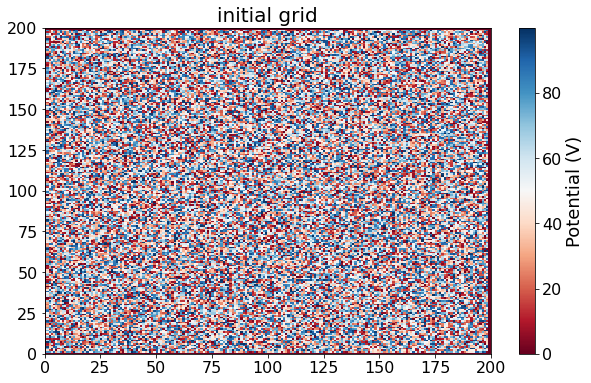

In [54]:
#define the size of our relaxation grid
rows = 200
columns = 200

#populate the grid, either with a uniform initial value or with random values
#(only one of the two lines below can be used at a time.)
#grid = np.ones([rows,columns])*25
grid = np.random.rand(rows,columns)*100

#for our 5x5 grid, choose initial conditions that mirror our intuition of what the solution should look like.
#(set each value by hand here; in general we might want to use a function to do this)
#grid[1,1] = 10
#grid[1,2] = 25
#grid[1,3] = 10
#grid[2,1] = 25
#grid[2,2] = 50
#grid[2,3] = 25
#grid[3,1] = 50
#grid[3,2] = 75
#grid[3,3] = 50

#define a separate array to store information about charges that we want to insert in this space.
charges = np.zeros([rows,columns])
charges[85,50:150] = 100
charges[115,50:150] = -100

#set boundary conditions
grid[0,:] = 0
grid[:,0] = 0
grid[:,columns-1] = 0
grid[rows-1,:] = 0

#make a plot to show our initial conditions as a pixellated, colored contour map.
z_min, z_max = grid.min(), grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('initial grid' )
plt.savefig('200x200_initial_grid.jpg', bbox_inches='tight')    

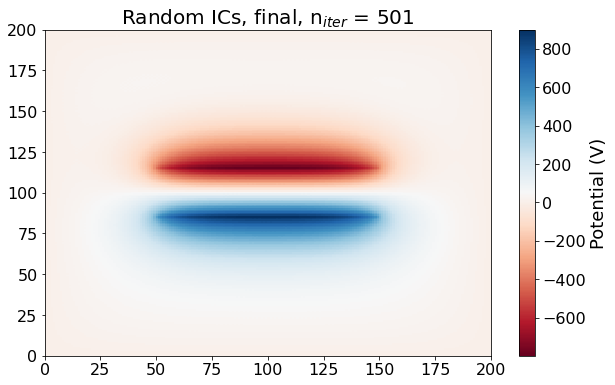

In [71]:
#save a copy of the input grid
initialGrid = np.copy(grid)

#perform the relaxation method
finalGrid, iterations = relaxGrid(grid, 0.5, limit = 500, charges = charges)

#plot the final grid
z_min, z_max = finalGrid.min(), finalGrid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
#print(np.flipud(finalGrid))
plt.savefig('200x200_final_grid.jpg', bbox_inches='tight')    

In [75]:
#find the electric field by locating the gradient in the potential
#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def findField(grid):
 
    xdimension = len(grid[0,:])
    ydimension = len(grid[:,0])
    
    X, Y = np.meshgrid(np.arange(0,xdimension,1),np.arange(0,ydimension,1))
    
    deltax = np.zeros([xdimension, ydimension])
    deltay = np.zeros([xdimension, ydimension])
        
    #use two loops to loop over rows and columns
    for i in range(1,xdimension-1):
        for j in range(1,ydimension-1):

            deltax[i,j] = -(grid[i,j+1] - grid[i,j-1])
            deltay[i,j] = -(grid[i+1,j] - grid[i-1,j])
 
    #print('loopy')

    return X, Y, deltax, deltay

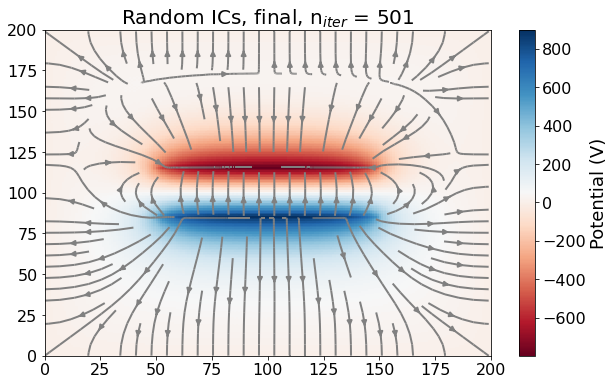

In [76]:
X, Y, ex, ey = findField(finalGrid)

#fig1 = plt.figure(figsize=(8, 8))
#ax1 = fig1.add_subplot(111)
#ax1.quiver(X, Y, ey, ex)
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.streamplot(X, Y, ex, ey, density=1, color = 'grey')
#print(np.flipud(finalGrid))
plt.savefig('200x200_final_grid_withField.jpg', bbox_inches='tight')    

In [ ]:
#determine how the grid evolved
diff_grid = finalGrid - initialGrid

#plot the difference grid.
z_min, z_max = diff_grid.min(), diff_grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), diff_grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('25s, diff_grid, n$_{iter}$ = '+str(iterations) )
print(np.flipud(finalGrid))
plt.savefig('5x5_diff_plaid.jpg', bbox_inches='tight')    